In [1]:
from google.colab import files
uploaded = files.upload()

Saving Customers_f.xlsx to Customers_f.xlsx


In [2]:
from google.colab import files
uploaded = files.upload()

Saving Sales.xlsx to Sales.xlsx


In [3]:
import pandas as pd

customers = pd.read_excel("Customers_f.xlsx")
sales = pd.read_excel("Sales.xlsx")

In [4]:
sales["sale_date"] = pd.to_datetime(sales["sale_date"])
cutoff_date = pd.Timestamp("2023-07-01")  # You can adjust this

# Split into past and future
past_sales = sales[sales["sale_date"] < cutoff_date]
future_sales = sales[sales["sale_date"] >= cutoff_date]


In [5]:
past_features = past_sales.groupby("code_customer").agg(
    past_purchases=("code_sale", "count"),
    total_spent=("Estimated_Unit_Price", "sum"),
    avg_order_value=("Estimated_Unit_Price", "mean"),
    unique_products=("SKU", "nunique"),
    discount_rate=("is_discounted", "mean"),
    recency_days=("sale_date", lambda x: (cutoff_date - x.max()).days),
    tenure_days=("sale_date", lambda x: (cutoff_date - x.min()).days)
).reset_index()


In [6]:
future_labels = future_sales.groupby("code_customer").agg(
    future_purchases=("code_sale", "count")
).reset_index()


In [7]:
df = past_features.merge(future_labels, on="code_customer", how="left")
df["future_purchases"] = df["future_purchases"].fillna(0)


In [8]:
full_df = customers.merge(df, on="code_customer", how="left")
full_df["future_purchases"] = full_df["future_purchases"].fillna(0)


In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Separate features and target
X = full_df.drop(columns=["code_customer", "future_purchases"], errors="ignore")
y = full_df["future_purchases"]

# Identify column types
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Build preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



Linear Regression
R²: -0.10101812113414343
RMSE: 7.8803543422455435

Random Forest
R²: -0.05329347458395706
RMSE: 7.707671724898733

XGBoost
R²: -0.1807842254638672
RMSE: 8.160819574972473


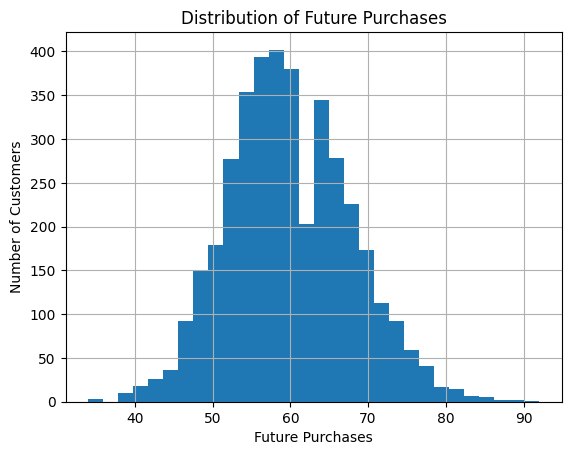

In [12]:
import matplotlib.pyplot as plt
full_df["future_purchases"].hist(bins=30)
plt.xlabel("Future Purchases")
plt.ylabel("Number of Customers")
plt.title("Distribution of Future Purchases")
plt.show()


In [13]:
# Fix review score
customers["Overall_review"] = (
    customers["Overall_review"]
    .astype(str).str.replace(",", ".", regex=False)
    .astype(float)
)

# Map subscription to binary
customers["is_subscribed"] = customers["Subscription Status"].map({"Yes": 1, "No": 0}).fillna(0)

# Map frequency to numeric
freq_map = {
    "Weekly": 4.0,
    "Fortnightly": 2.0,
    "Monthly": 1.0,
    "Quarterly": 1/3,
    "Occasional": 0.25
}
customers["freq_per_month"] = customers["Frequency of Purchases"].map(freq_map).fillna(0.5)

# Merge enriched profile with past features + future labels
full_df = customers.merge(df, on="code_customer", how="left")
full_df["future_purchases"] = full_df["future_purchases"].fillna(0)


In [14]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Drop identifiers and target
X = full_df.drop(columns=["code_customer", "future_purchases"], errors="ignore")
y = full_df["future_purchases"]

# Identify column types
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
])

X_processed = preprocessor.fit_transform(X)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)


In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=5, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("R²:", r2_score(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))



Linear Regression
R²: -0.1010179043991486
RMSE: 7.880353566623141

Random Forest
R²: -0.04691911042507857
RMSE: 7.684313531112876

XGBoost
R²: -0.15101277828216553
RMSE: 8.05728240815025


In [17]:
corr = full_df.corr(numeric_only=True)["future_purchases"].sort_values(ascending=False)
print(corr)


future_purchases      1.000000
discount_rate         0.017360
freq_per_month        0.010776
avg_order_value       0.007111
Overall_review        0.003818
total_spent          -0.000609
recency_days         -0.006021
past_purchases       -0.006171
unique_products      -0.007097
Age                  -0.007188
is_subscribed        -0.007352
tenure_days          -0.010084
Previous Purchases   -0.011058
code_customer        -0.013736
Name: future_purchases, dtype: float64


In [24]:
# Purchases per month of tenure
full_df["purchases_per_month"] = full_df["past_purchases"] / (full_df["tenure_days"]/30).clip(lower=1)

# Discount sensitivity: ratio of discounted purchases to total
full_df["discount_sensitivity"] = full_df["discount_rate"].fillna(0)

# Variety index: unique products / past purchases
full_df["variety_index"] = full_df["unique_products"] / full_df["past_purchases"].replace(0,1)

# Monetary intensity: total_spent / past_purchases
full_df["monetary_intensity"] = full_df["total_spent"] / full_df["past_purchases"].replace(0,1)

# Recent activity: recency normalized by tenure
full_df["recency_ratio"] = full_df["recency_days"] / full_df["tenure_days"].replace(0,1)


In [25]:
import numpy as np
y_log = np.log1p(full_df["future_purchases"])


In [28]:
import numpy as np
y_log = np.log1p(y)  # log-transform target

from sklearn.model_selection import train_test_split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_processed, y_log, test_size=0.2, random_state=42
)


In [29]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train_log)  # train on log target
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # inverse transform predictions
    y_true = np.expm1(y_test_log)  # inverse transform ground truth
    print(f"\n{name}")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))



Ridge
R²: -0.07147879043770633
RMSE: 7.773924205814788

Lasso
R²: -0.007423236095323471
RMSE: 7.537971557979608

Gradient Boosting
R²: -0.11990694736269147
RMSE: 7.9476637020446415


In [30]:
# Purchases in the last 30 days before cutoff
recent_cutoff = cutoff_date - pd.Timedelta(days=30)
recent_sales = past_sales[past_sales["sale_date"] >= recent_cutoff]

recent_activity = recent_sales.groupby("code_customer").agg(
    recent_purchases=("code_sale", "count"),
    recent_spent=("Estimated_Unit_Price", "sum"),
    recent_unique_products=("SKU", "nunique")
).reset_index()

# Merge into full_df
full_df = full_df.merge(recent_activity, on="code_customer", how="left").fillna(0)


In [31]:
# Spend per product
full_df["spend_per_product"] = full_df["total_spent"] / full_df["unique_products"].replace(0,1)

# Discount ratio
full_df["discount_ratio"] = full_df["discount_rate"] * full_df["past_purchases"]

# Activity intensity
full_df["activity_intensity"] = full_df["past_purchases"] / full_df["recency_days"].replace(0,1)

# Tenure-normalized purchases
full_df["purchases_per_month"] = full_df["past_purchases"] / (full_df["tenure_days"]/30).clip(lower=1)


In [32]:
# Rebuild X and y
X = full_df.drop(columns=["code_customer", "future_purchases"], errors="ignore")
y = full_df["future_purchases"]

# Log-transform target
y_log = np.log1p(y)

# Train/test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_processed, y_log, test_size=0.2, random_state=42
)

# Train models
for name, model in models.items():
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)
    print(f"\n{name}")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))



Ridge
R²: -0.07147879043770633
RMSE: 7.773924205814788

Lasso
R²: -0.007423236095323471
RMSE: 7.537971557979608

Gradient Boosting
R²: -0.11990694736269147
RMSE: 7.9476637020446415


In [33]:
# Future purchases per month of tenure
full_df["future_rate"] = full_df["future_purchases"] / (full_df["tenure_days"]/30).clip(lower=1)

# Define new target
y = full_df["future_rate"]

# Log-transform target for stability
y_log = np.log1p(y)


In [34]:
X = full_df.drop(columns=["code_customer", "future_purchases", "future_rate"], errors="ignore")

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_processed, y_log, test_size=0.2, random_state=42
)


In [35]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # inverse transform predictions
    y_true = np.expm1(y_test_log)  # inverse transform ground truth
    print(f"\n{name}")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))



Ridge
R²: 0.031172324329904355
RMSE: 0.2962923575939476

Lasso
R²: 0.08791754392381324
RMSE: 0.2874843664603377

Gradient Boosting
R²: -0.0206089312682054
RMSE: 0.30410731283083975


In [36]:
import pandas as pd

# Get feature names from preprocessing pipeline
feature_names = preprocessor.get_feature_names_out()

# Extract coefficients from Lasso
coef = models["Lasso"].coef_

# Build importance dataframe
importance_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
}).sort_values("coefficient", ascending=False)

# Show top positive and negative drivers
print("Top Positive Features:")
print(importance_df.head(10))

print("\nTop Negative Features:")
print(importance_df.tail(10))


Top Positive Features:
                                     feature  coefficient
265                    cat__Preferred_size_M     0.001245
4                        num__freq_per_month     0.000487
9                         num__discount_rate     0.000355
197   cat__Zip_code_Portsmouth_New Hampshire     0.000000
196            cat__Zip_code_Portland_Oregon    -0.000000
195             cat__Zip_code_Portland_Maine     0.000000
194            cat__Zip_code_Pocatello_Idaho     0.000000
193    cat__Zip_code_Pittsburgh_Pennsylvania    -0.000000
192            cat__Zip_code_Phoenix_Arizona    -0.000000
191  cat__Zip_code_Philadelphia_Pennsylvania    -0.000000

Top Negative Features:
                                   feature  coefficient
98     cat__Zip_code_Gaithersburg_Maryland    -0.000000
97        cat__Zip_code_Frederick_Maryland     0.000000
96          cat__Zip_code_Fort Worth_Texas    -0.000000
104      cat__Zip_code_Green Bay_Wisconsin    -0.000000
0                                 n

In [37]:
# Keep only meaningful features
selected_features = [
    "freq_per_month",
    "discount_rate",
    "recency_days",
    "tenure_days",
    "past_purchases",
    "unique_products",
    "total_spent",
    "Overall_review",
    "is_subscribed",
    "purchases_per_month",
    "discount_sensitivity",
    "variety_index",
    "monetary_intensity",
    "recency_ratio",
    "spend_per_product",
    "discount_ratio",
    "activity_intensity",
    "recent_purchases",
    "recent_spent",
    "recent_unique_products"
]

X = full_df[selected_features]
y = full_df["future_rate"]   # normalized target
y_log = np.log1p(y)


In [38]:
from sklearn.preprocessing import StandardScaler

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)


In [39]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001)
}

for name, model in models.items():
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)
    print(f"\n{name}")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))



Ridge
R²: 0.08651069734649208
RMSE: 0.2877059969468798

Lasso
R²: 0.08635502118183702
RMSE: 0.2877305112230513


In [40]:
from sklearn.model_selection import cross_val_score

# Evaluate Lasso with 5-fold CV
scores = cross_val_score(models["Lasso"], X_scaled, y_log, cv=5, scoring="r2")

print("Cross-Validation R² scores:", scores)
print("Mean R²:", scores.mean())
print("Std Dev:", scores.std())


Cross-Validation R² scores: [0.09096191 0.0827956  0.06397609 0.06959246 0.05761767]
Mean R²: 0.0729887469623286
Std Dev: 0.012233083698744745


In [41]:
# Define cutoffs
recent_cutoff = cutoff_date - pd.Timedelta(days=30)
mid_cutoff = cutoff_date - pd.Timedelta(days=90)

# Recent (last 30 days)
recent_sales = past_sales[past_sales["sale_date"] >= recent_cutoff]
recent_activity = recent_sales.groupby("code_customer").agg(
    recent_purchases=("code_sale", "count"),
    recent_spent=("Estimated_Unit_Price", "sum")
).reset_index()

# Mid-term (30–90 days ago)
mid_sales = past_sales[(past_sales["sale_date"] < recent_cutoff) & (past_sales["sale_date"] >= mid_cutoff)]
mid_activity = mid_sales.groupby("code_customer").agg(
    mid_purchases=("code_sale", "count"),
    mid_spent=("Estimated_Unit_Price", "sum")
).reset_index()

# Merge into full_df
full_df = full_df.merge(recent_activity, on="code_customer", how="left").fillna(0)
full_df = full_df.merge(mid_activity, on="code_customer", how="left").fillna(0)

# Trend ratios
full_df["purchase_trend"] = (full_df["recent_purchases"]+1) / (full_df["mid_purchases"]+1)
full_df["spend_trend"] = (full_df["recent_spent"]+1) / (full_df["mid_spent"]+1)


KeyError: 'recent_purchases'

In [42]:
# Define cutoffs
recent_cutoff = cutoff_date - pd.Timedelta(days=30)
mid_cutoff = cutoff_date - pd.Timedelta(days=90)

# Recent (last 30 days)
recent_sales = past_sales[past_sales["sale_date"] >= recent_cutoff]
recent_activity = recent_sales.groupby("code_customer").agg(
    purchases=("code_sale", "count"),
    spent=("Estimated_Unit_Price", "sum")
).add_prefix("recent_").reset_index()

# Mid-term (30–90 days ago)
mid_sales = past_sales[(past_sales["sale_date"] < recent_cutoff) & (past_sales["sale_date"] >= mid_cutoff)]
mid_activity = mid_sales.groupby("code_customer").agg(
    purchases=("code_sale", "count"),
    spent=("Estimated_Unit_Price", "sum")
).add_prefix("mid_").reset_index()

# Merge into full_df
full_df = full_df.merge(recent_activity, on="code_customer", how="left").fillna(0)
full_df = full_df.merge(mid_activity, on="code_customer", how="left").fillna(0)

# Trend ratios (safe, no KeyError)
full_df["purchase_trend"] = (full_df["recent_purchases"] + 1) / (full_df["mid_purchases"] + 1)
full_df["spend_trend"] = (full_df["recent_spent"] + 1) / (full_df["mid_spent"] + 1)


KeyError: 'mid_purchases'

In [43]:
# Mid-term (30–90 days ago)
mid_sales = past_sales[(past_sales["sale_date"] < recent_cutoff) & (past_sales["sale_date"] >= mid_cutoff)]
mid_activity = mid_sales.groupby("code_customer").agg(
    purchases=("code_sale", "count"),
    spent=("Estimated_Unit_Price", "sum")
).add_prefix("mid_").reset_index()

# Merge into full_df
full_df = full_df.merge(mid_activity, on="code_customer", how="left").fillna(0)

# Ensure columns exist even if groupby was empty
for col in ["mid_purchases", "mid_spent"]:
    if col not in full_df.columns:
        full_df[col] = 0

# Do the same for recent
for col in ["recent_purchases", "recent_spent"]:
    if col not in full_df.columns:
        full_df[col] = 0

# Trend ratios (safe)
full_df["purchase_trend"] = (full_df["recent_purchases"] + 1) / (full_df["mid_purchases"] + 1)
full_df["spend_trend"] = (full_df["recent_spent"] + 1) / (full_df["mid_spent"] + 1)


In [44]:
from sklearn.preprocessing import StandardScaler

# Scale numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, y_log, test_size=0.2, random_state=42
)


In [45]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001)
}

for name, model in models.items():
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test_log)
    print(f"\n{name}")
    print("R²:", r2_score(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


Ridge
R²: 0.08651069734649208
RMSE: 0.2877059969468798

Lasso
R²: 0.08635502118183702
RMSE: 0.2877305112230513


In [46]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

# ElasticNet with balanced mix of L1 and L2
elastic = ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42)

# Train
elastic.fit(X_train, y_train_log)

# Predict
y_pred_log = elastic.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_log)

print("ElasticNet")
print("R²:", r2_score(y_true, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))


ElasticNet
R²: 0.08613200299840329
RMSE: 0.2877656261867518


In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(elastic, X_scaled, y_log, cv=5, scoring="r2")
print("Cross-Validation R² scores:", scores)
print("Mean R²:", scores.mean())
print("Std Dev:", scores.std())


Cross-Validation R² scores: [0.09059937 0.08136123 0.06351745 0.06802956 0.05524354]
Mean R²: 0.07175023302583776
Std Dev: 0.012662969635704893


In [ ]:
import joblib

# Sauvegarder le modèle ElasticNet
joblib.dump(elastic, 'ghada_regression_model.pkl')
print("Modèle ElasticNet sauvegardé : ghada_regression_model.pkl")

# Sauvegarder le scaler
joblib.dump(scaler, 'ghada_regression_scaler.pkl')
print("Scaler sauvegardé : ghada_regression_scaler.pkl")

# Aucun encodeur n'est utilisé (features numériques uniquement)
print("Aucun encodeur à sauvegarder (features numériques uniquement).")

print("\nTous les fichiers .pkl ont été sauvegardés avec succès !")